In [2]:
import torch
from torch.nn import Module, Linear, SiLU, Embedding
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import global_add_pool
from utils.data_get_utils import get_dataset, get_dataloaders
from utils.model_utils import bessel_rbf, cosine_cutoff, sanity_check

In [3]:
dataset = get_dataset(version='apricot', molecule='benzene')
dataloader, _, _ = get_dataloaders(version='apricot', molecule='benzene', train_split=0.01, val_split=0.98, test_split=0.01, batch_size=32)
data = dataset[0]

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [4]:
class PAINNPrediction(Module):
    def __init__(self):
        super().__init__()
        
        self.linear_1 = Linear(16, 16)
        self.linear_2 = Linear(16, 1)
        
        self.act = SiLU()
        
    def forward(self, x, data, pos):
        s = x[:, int(x.shape[1]*0.75):]
        
        s = self.linear_1(s)
        s = self.act(s)
        s = self.linear_2(s)
        
        E_hat = global_add_pool(s, data.batch)
        
        F_hat = -torch.autograd.grad(E_hat.sum(), pos, retain_graph=True)[0]
        
        return E_hat, F_hat

In [5]:
class PAINNMessage(MessagePassing):
    def __init__(self):
        super().__init__()
        
        self.act = SiLU()
        
        self.linear_1 = Linear(16,16)
        self.linear_2 = Linear(20,48)
        self.linear_3 = Linear(16,48)
        
    def forward(self, x, edge_index, edge_attr1, edge_attr2):
        x = self.propagate(x=x, edge_index=edge_index, edge_attr1=edge_attr1, edge_attr2=edge_attr2)
        
        return x
        
    def message(self, x_j, edge_index, edge_attr1, edge_attr2):
        v_j = x_j[:,:int(x_j.shape[1] * 0.75)]
        s_j = x_j[:,int(x_j.shape[1] * 0.75):]
        
        s_j = self.linear_1(s_j)
        s_j = self.act(s_j)
        s_j = self.linear_3(s_j)
        
        unit_edge_vec = edge_attr1
        edge_vec_length = edge_attr2.view(-1,1)
        
        edge_basis = bessel_rbf(x=edge_vec_length, n=20, r_cut=1.4415) * cosine_cutoff(x=edge_vec_length, r_cut=1.4415)
        edge_basis = self.linear_2(edge_basis)
        
        split = s_j * edge_basis
        even_third = int(split.shape[1]/3)
        split_1 = split[:, :even_third]
        split_2 = split[:, even_third:-even_third]
        split_3 = split[:, -even_third:]
        
        split_1.unsqueeze_(dim=2)
        
        v_j = v_j.view(-1,16,3)
        v_j = v_j * split_1
        
        v_j += torch.einsum('ni,nj->nij', split_3, unit_edge_vec)
        
        s_j = split_2
        
        out = torch.cat((v_j.view(v_j.size(0), -1), s_j), dim=1)
        
        return out
        
    def update(self, aggr_out, x):
        x += aggr_out
        
        return x

In [76]:
class PAINNUpdate(MessagePassing):
    def __init__(self):
        super().__init__()
        
        self.act = SiLU()
        
        self.U = Linear(16,16,bias=False)
        self.V = Linear(16,16,bias=False)
        
        self.linear_1 = Linear(32,16)
        self.linear_2 = Linear(16,48)
    
    def forward(self, x, edge_index):
        x = self.propagate(x=x, edge_index=edge_index)
        
        return x
        
    def message(self, x_j):
        v = x_j[:,:int(x_j.shape[1] * 0.75)]
        s = x_j[:,int(x_j.shape[1] * 0.75):]
        
        v = v.view(v.shape[0],3,16)
        v = self.U(v)
        v_V = self.V(v)
        v = v.view(v.shape[0],16,3)
        v_V = v_V.view(v_V.shape[0],16,3)
        
        stack_in = torch.norm(v_V, p=2, dim=2)
        
        stack = torch.cat((stack_in, s), dim=1)
        
        s = self.linear_1(stack)
        s = self.act(s)
        split = self.linear_2(s)
        
        even_third = int(split.shape[1]/3)
        split_1 = split[:,:even_third]    
        split_2 = split[:,even_third:-even_third]
        split_3 = split[:,-even_third:]
        
        v = v * split_1.unsqueeze(dim=2)
        
        v_V = torch.einsum('ijk,ijk->ij', v, v_V)  
        v_v = v_V * split_2
        v_V = v_V + split_3
        
        v = v.view(v.shape[0], -1)
        
        x = torch.cat((v, v_V), dim=1)
        
        return x
    
    def update(self, aggr_out, x):
        x += aggr_out
    
        return x

In [77]:
class PAINNBlock(Module):
    def __init__(self):
        super().__init__()
        
        self.message = PAINNMessage()
        self.update = PAINNUpdate()
    
    def forward(self, x, edge_index, edge_attr1, edge_attr2):
        x = self.message(x, edge_index, edge_attr1, edge_attr2)
        x = self.update(x, edge_index)
        
        return x

In [78]:
class PAINN(Module):
    def __init__(self):
        super().__init__()
        
        self.embedding = Embedding(118,16)
        self.block_1 = PAINNBlock()
        self.block_2 = PAINNBlock()
        self.block_3 = PAINNBlock()
        self.prediction = PAINNPrediction()
    
    def forward(self, data):
        edge_index = data.edge_index
        pos = data.pos
        pos.requires_grad_(True)
        
        idx1 = edge_index[0]
        idx2 = edge_index[1]
        edge_vec = data.pos[idx1] - data.pos[idx2]
        edge_vec_length = torch.norm(edge_vec, dim=1)
        unit_edge_vec = torch.div(edge_vec, edge_vec_length.view(-1,1))
        
        v = torch.zeros(data.num_nodes, 16, 3)
        s = self.embedding(data.z)
        
        x = torch.cat((v.view(v.shape[0], -1), s), dim=1)
        
        x = self.block_1(x=x, edge_index=edge_index, edge_attr1=unit_edge_vec, edge_attr2=edge_vec_length)
        x = self.block_2(x=x, edge_index=edge_index, edge_attr1=unit_edge_vec, edge_attr2=edge_vec_length)
        x = self.block_3(x=x, edge_index=edge_index, edge_attr1=unit_edge_vec, edge_attr2=edge_vec_length)
        
        F_hat, E_hat = self.prediction(x, data, pos)
        
        return F_hat, E_hat

In [79]:
model = PAINN()

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


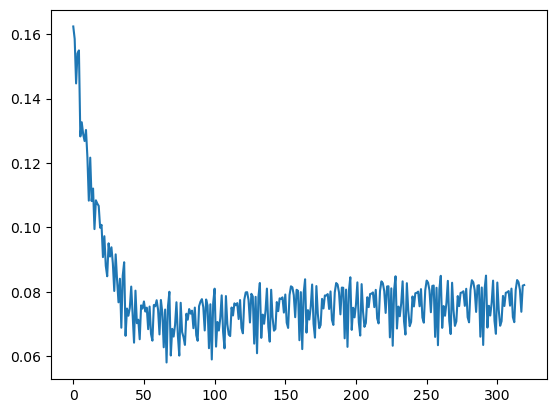

In [80]:
sanity_check(model, batch_size=8)